# Project- ANIMAL-45 Image Classification

**How to approach an Image classification task?**

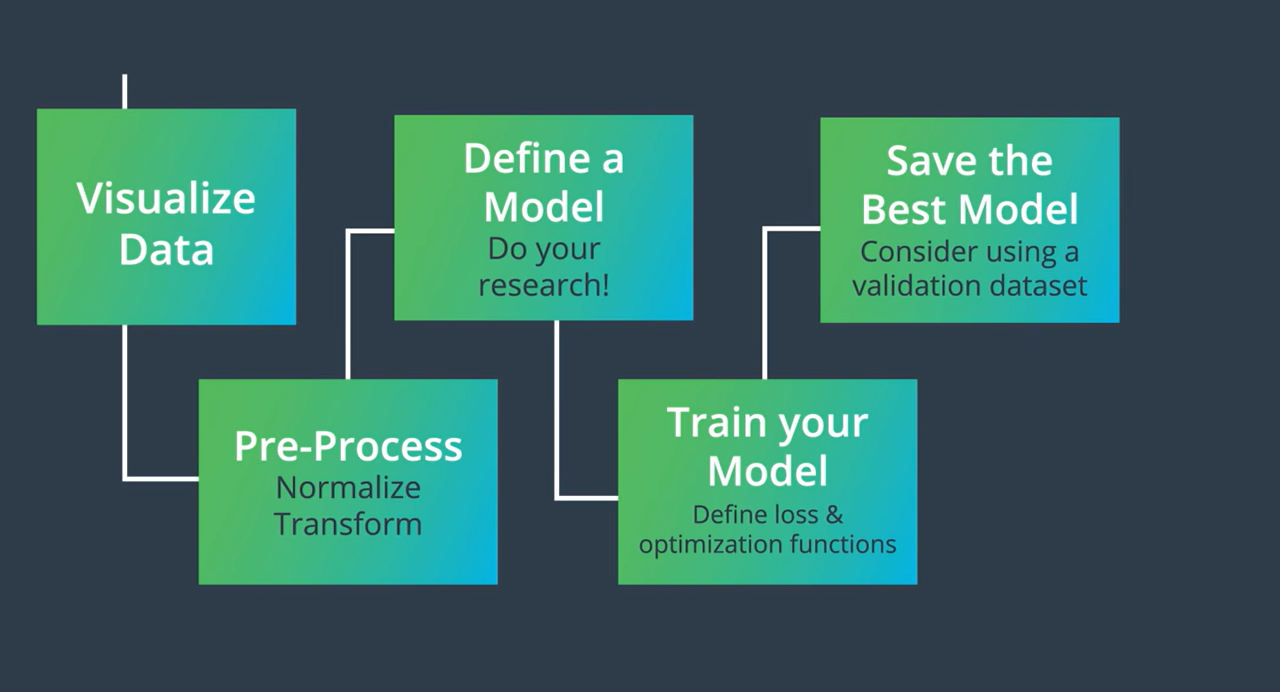

# Importing the dependencies

In [3]:
import numpy as np
import pandas as pd
import PIL
import os
import zipfile
import torch
import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor
from torch import nn
import matplotlib.pyplot as plt
# Check versions
# Note: your PyTorch version shouldn't be lower than 1.10.0 and torchvision version shouldn't be lower than 0.11
print(f"PyTorch version: {torch.__version__}\ntorchvision version: {torchvision.__version__}")


PyTorch version: 2.1.0+cu121
torchvision version: 0.16.0+cu121


# Unzipping the Uploaded file

In [ ]:
# Unzipping the Uploaded file
!unzip '/content/drive/MyDrive/mammals.zip'

In [5]:
from IPython.display import clear_output
clear_output()

# Formatting the data
1. The available data is not Divided into Training ,Validation and Test data
2. For model Evaluation we need the data to be divided into validation and test set
3. I'll be using os to extract all images and then divide them into training,validation and test images

In [ ]:
import os
import shutil
import numpy as np

def split_data(source_folder, target_folder, train_size=0.7, val_size=0.2):
    # Ensure train_size and val_size sum up to less than 1
    if train_size + val_size >= 1:
        raise ValueError("train_size and val_size sum should be less than 1")

    classes = os.listdir(source_folder)
    for cls in classes:
        os.makedirs(os.path.join(target_folder, 'train', cls), exist_ok=True)
        os.makedirs(os.path.join(target_folder, 'val', cls), exist_ok=True)
        os.makedirs(os.path.join(target_folder, 'test', cls), exist_ok=True)

        # Get a list of pictures
        all_images = os.listdir(os.path.join(source_folder, cls))
        np.random.shuffle(all_images)  # Shuffle the list

        # Calculate split indices
        train_split_index = int(len(all_images) * train_size)
        val_split_index = train_split_index + int(len(all_images) * val_size)

        # Splitting the dataset
        train_images = all_images[:train_split_index]
        val_images = all_images[train_split_index:val_split_index]
        test_images = all_images[val_split_index:]

        # Copying files to train, val, and test directories
        for image in train_images:
            source_path = os.path.join(source_folder, cls, image)
            dest_path = os.path.join(target_folder, 'train', cls, image)
            shutil.copyfile(source_path, dest_path)

        for image in val_images:
            source_path = os.path.join(source_folder, cls, image)
            dest_path = os.path.join(target_folder, 'val', cls, image)
            shutil.copyfile(source_path, dest_path)

        for image in test_images:
            source_path = os.path.join(source_folder, cls, image)
            dest_path = os.path.join(target_folder, 'test', cls, image)
            shutil.copyfile(source_path, dest_path)

# Usage
source_folder = '/content/mammals' # Your original folder
target_folder = '/content' # Where to save the reorganized structure
split_data(source_folder, target_folder)


**Save date Path in variables**

In [ ]:
train_data='/content/train'
test_data='/content/test'
val_data='/content/val'

# Loading Data
The easiest way to load image data is with **datasets.ImageFolder** from torchvision . In general you'll use ImageFolder like so:

**dataset = datasets.ImageFolder('path/to/data', transform=transform)**

where 'path/to/data' is the file path to the data directory and transform is a list of processing steps built with the transforms module from torchvision. ImageFolder expects the files and directories to be constructed like so:

**root/dog/xxx.png**

**root/dog/xxy.png**

**root/dog/xxz.png**

**root/cat/123.png**

**root/cat/nsdf3.png**

**root/cat/asd932_.png**

where each class has its own directory cat and dog for the images. The images are then labeled with the class taken from the directory name. So here, the image 123.png would be loaded with the class label cat. You can download the

### Transforms

When you load in the data with `ImageFolder`, you'll need to define some transforms. For example, the images are different sizes but we'll need them to all be the same size for training. You can either resize them with `transforms.Resize()` or crop with `transforms.CenterCrop()`, `transforms.RandomResizedCrop()`, etc. We'll also need to convert the images to PyTorch tensors with `transforms.ToTensor()`. Typically you'll combine these transforms into a pipeline with `transforms.Compose()`, which accepts a list of transforms and runs them in sequence. It looks something like this to scale, then crop, then convert to a tensor:

```python
transform = transforms.Compose([transforms.Resize(255),
                                 transforms.CenterCrop(224),
                                 transforms.ToTensor()])

```

There are plenty of transforms available,  you can read through the [documentation](http://pytorch.org/docs/master/torchvision/transforms.html).


---



## Data Augmentation

A common strategy for training neural networks is to introduce randomness in the input data itself. For example, you can randomly rotate, mirror, scale, and/or crop your images during training. This will help your network generalize as it's seeing the same images but in different locations, with different sizes, in different orientations, etc.

To randomly rotate, scale and crop, then flip your images you would define your transforms like this:

```python
train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                       transforms.RandomResizedCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.5, 0.5, 0.5],
                                                            [0.5, 0.5, 0.5])])
```

You'll also typically want to normalize images with `transforms.Normalize`. You pass in a list of means and list of standard deviations, then the color channels are normalized like so

```input[channel] = (input[channel] - mean[channel]) / std[channel]```

Subtracting `mean` centers the data around zero and dividing by `std` squishes the values to be between -1 and 1. Normalizing helps keep the network work weights near zero which in turn makes backpropagation more stable. Without normalization, networks will tend to fail to learn.

You can find a list of all [the available transforms here](http://pytorch.org/docs/0.3.0/torchvision/transforms.html). When you're testing however, you'll want to use images that aren't altered (except you'll need to normalize the same way). So, for validation/test images, you'll typically just resize and crop.


In [ ]:
from torchvision import datasets, transforms


train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                       transforms.RandomResizedCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])])



test_transforms = transforms.Compose([transforms.Resize(255),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor()])

val_transforms=transforms.Compose([transforms.Resize(255),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor()])


In [ ]:
# pass the image data folder and
# transform function to the datasets
# .imagefolder function
train_data = datasets.ImageFolder(train_data,
                               transform=train_transforms)

val_data = datasets.ImageFolder(val_data,
                               transform=val_transforms)

test_data=train_data = datasets.ImageFolder(test_data,
                               transform=test_transforms)



In [ ]:
print(f"Train data:\n{train_data}\nTest data:\n{test_data}")

Train data:
Dataset ImageFolder
    Number of datapoints: 1418
    Root location: /content/test
    StandardTransform
Transform: Compose(
               Resize(size=255, interpolation=bilinear, max_size=None, antialias=warn)
               CenterCrop(size=(224, 224))
               ToTensor()
           )
Test data:
Dataset ImageFolder
    Number of datapoints: 1418
    Root location: /content/test
    StandardTransform
Transform: Compose(
               Resize(size=255, interpolation=bilinear, max_size=None, antialias=warn)
               CenterCrop(size=(224, 224))
               ToTensor()
           )


In [ ]:
# Get class names as a list
class_names = train_data.classes
print("Class names: ",class_names)

# Can also get class names as a dict
class_dict = train_data.class_to_idx
print("Class names as a dict: ",class_dict)

# Check the lengths
print("The lengths of the training and test sets: ", len(train_data), len(test_data))

Class names:  ['african_elephant', 'alpaca', 'american_bison', 'anteater', 'arctic_fox', 'armadillo', 'baboon', 'badger', 'blue_whale', 'brown_bear', 'camel', 'dolphin', 'giraffe', 'groundhog', 'highland_cattle', 'horse', 'jackal', 'kangaroo', 'koala', 'manatee', 'mongoose', 'mountain_goat', 'opossum', 'orangutan', 'otter', 'polar_bear', 'porcupine', 'red_panda', 'rhinoceros', 'sea_lion', 'seal', 'snow_leopard', 'squirrel', 'sugar_glider', 'tapir', 'vampire_bat', 'vicuna', 'walrus', 'warthog', 'water_buffalo', 'weasel', 'wildebeest', 'wombat', 'yak', 'zebra']
Class names as a dict:  {'african_elephant': 0, 'alpaca': 1, 'american_bison': 2, 'anteater': 3, 'arctic_fox': 4, 'armadillo': 5, 'baboon': 6, 'badger': 7, 'blue_whale': 8, 'brown_bear': 9, 'camel': 10, 'dolphin': 11, 'giraffe': 12, 'groundhog': 13, 'highland_cattle': 14, 'horse': 15, 'jackal': 16, 'kangaroo': 17, 'koala': 18, 'manatee': 19, 'mongoose': 20, 'mountain_goat': 21, 'opossum': 22, 'orangutan': 23, 'otter': 24, 'polar_b

1. The shape of the tensor shows  [3,224,224]  which shows [C,W,H]  i.e color channel,width and height of the given image
2. The datatype is float32


In [ ]:
img, label = train_data[0][0], train_data[0][1]
print(f"Image tensor:\n{img}")
print(f"Image shape: {img.shape}")
print(f"Image datatype: {img.dtype}")
print(f"Image label: {class_names[label]}")
print(f"Label datatype: {type(label)}")

Image tensor:
tensor([[[0.3020, 0.3020, 0.3020,  ..., 0.2627, 0.2667, 0.2863],
         [0.3098, 0.3020, 0.3020,  ..., 0.2627, 0.2667, 0.2941],
         [0.3137, 0.3137, 0.3137,  ..., 0.2627, 0.2627, 0.2863],
         ...,
         [0.8627, 0.8588, 0.8510,  ..., 0.0353, 0.0392, 0.0314],
         [0.8824, 0.8706, 0.8431,  ..., 0.0314, 0.0314, 0.0275],
         [0.5373, 0.4902, 0.4157,  ..., 0.0392, 0.0039, 0.0353]],

        [[0.6784, 0.6784, 0.6784,  ..., 0.6431, 0.6471, 0.6353],
         [0.6784, 0.6784, 0.6784,  ..., 0.6431, 0.6431, 0.6471],
         [0.6824, 0.6824, 0.6824,  ..., 0.6431, 0.6471, 0.6471],
         ...,
         [0.7804, 0.7765, 0.7804,  ..., 0.0118, 0.0235, 0.0235],
         [0.8235, 0.8118, 0.7922,  ..., 0.0157, 0.0275, 0.0275],
         [0.5137, 0.4745, 0.4000,  ..., 0.0431, 0.0078, 0.0353]],

        [[0.9686, 0.9686, 0.9686,  ..., 0.9451, 0.9255, 0.8980],
         [0.9686, 0.9686, 0.9686,  ..., 0.9451, 0.9333, 0.9098],
         [0.9647, 0.9647, 0.9647,  ..., 0.95

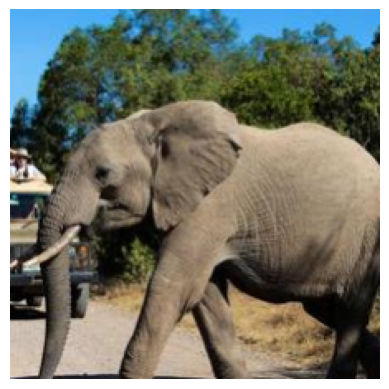

In [ ]:
img=train_data[0][0]
img=img.numpy()
img=img.transpose(1,2,0)
plt.imshow(img)
plt.axis('Off')
plt.show()

#Plotting some random images from the dataset

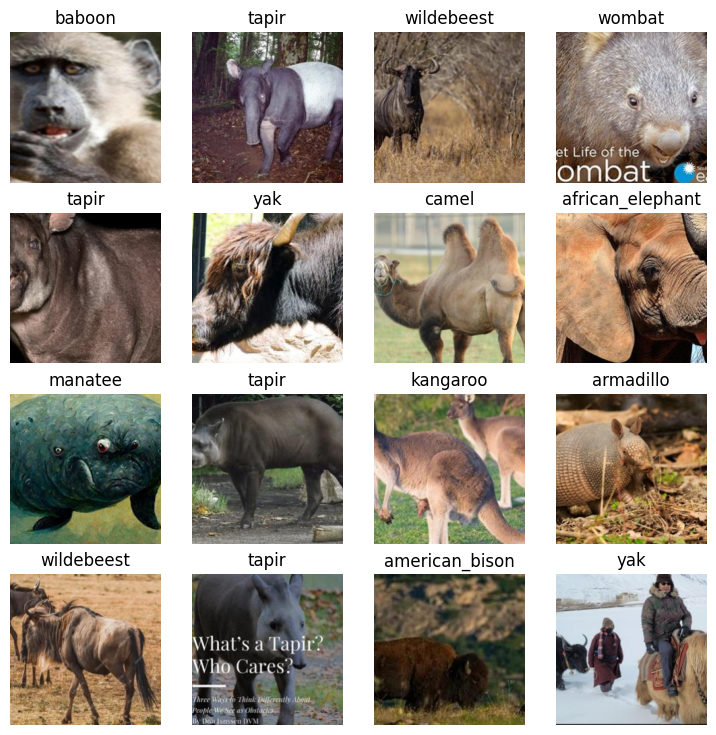

In [ ]:
# Plot more images
torch.manual_seed(42)
fig = plt.figure(figsize=(9, 9))
rows, cols = 4, 4
for i in range(1, rows * cols + 1):
    random_idx = torch.randint(0, len(train_data), size=[1]).item()
    img, label = train_data[random_idx]
    img=img.numpy()
    fig.add_subplot(rows, cols, i)
    plt.imshow(img.transpose(1,2,0), cmap="gray")
    plt.title(class_names[label])
    plt.axis(False);

### Data Loaders

With the `ImageFolder` loaded, you have to pass it to a [`DataLoader`](http://pytorch.org/docs/master/data.html#torch.utils.data.DataLoader). The `DataLoader` takes a dataset (such as you would get from `ImageFolder`) and returns batches of images and the corresponding labels. You can set various parameters like the batch size and if the data is shuffled after each epoch.

```python
dataloader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=True)
```

Here `dataloader` is a [generator](https://jeffknupp.com/blog/2013/04/07/improve-your-python-yield-and-generators-explained/). To get data out of it, you need to loop through it or convert it to an iterator and call `next()`.

```python
# Looping through it, get a batch on each loop
for images, labels in dataloader:
    pass

# Get one batch
images, labels = next(iter(dataloader))
```

In [ ]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_data, batch_size=64, shuffle=True)
val_dataloader = DataLoader(val_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)


In [ ]:
img, label = next(iter(train_dataloader))

# Note that batch size will now be 1.
print(f"Image shape: {img.shape} -> [batch_size, color_channels, height, width]")
print(f"Label shape: {label.shape}")
print(f"The number of batches are :{len(train_dataloader)}")

Image shape: torch.Size([64, 3, 224, 224]) -> [batch_size, color_channels, height, width]
Label shape: torch.Size([64])
The number of batches are :23


Feature batch shape: torch.Size([64, 3, 224, 224])
Labels batch shape: torch.Size([64])
Label: 1, class name is :alpaca


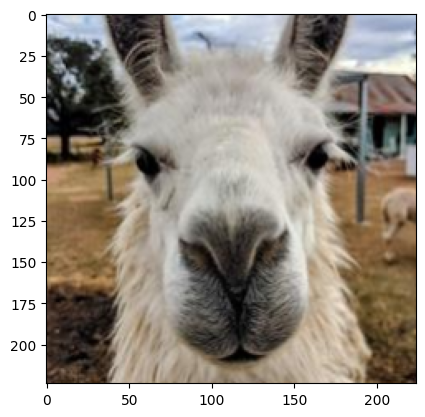

In [ ]:
# Display image and label.
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[0]
class_img=class_names[label]
img=img.numpy()
print(f"Label: {label}, class name is :{class_img}")
plt.imshow(img.transpose(1,2,0), cmap="gray")
plt.show()

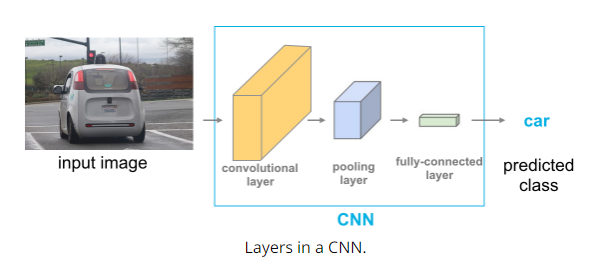

#Transfer Learning


The art of knowing how to use pre-trained networks to solved challenging problems in computer vision is Transfer Learning.  Specifically, I'll use network trained on [ImageNet](http://www.image-net.org/) [available from torchvision](http://pytorch.org/docs/0.3.0/torchvision/models.html).

ImageNet is a massive dataset with over 1 million labeled images in 1000 categories. It's used to train deep neural networks using an architecture called convolutional layers.

Once trained, these models work astonishingly well as feature detectors for images they weren't trained on. Using a pre-trained network on images not in the training set is called transfer learning. Here we'll use transfer learning to train a network that can classify our Animal 45  photos with near perfect accuracy.

With `torchvision.models`  download these pre-trained networks and use them in  applications. I'll include `models` in my imports now.

In [ ]:
from torchvision import  models
model=models.densenet121(pretrained=True)
model

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 45.0MB/s]


DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

This model is built out of two main parts, the features and the classifier. The features part is a stack of convolutional layers and overall works as a feature detector that can be fed into a classifier. The classifier part is a single fully-connected layer `(classifier): Linear(in_features=1024, out_features=1000)`. This layer was trained on the ImageNet dataset, so it won't work for our specific problem. That means we need to replace the classifier, but the features will work perfectly on their own. In general, I think about pre-trained networks as amazingly good feature detectors that can be used as the input for simple feed-forward classifiers.

In [ ]:
# Freeze parameters so we don't backprop through them
for param in model.parameters():
    param.requires_grad = False

from collections import OrderedDict
classifier = nn.Sequential(OrderedDict([
                          ('fc1', nn.Linear(1024, 500)),
                          ('relu', nn.ReLU()),
                          ('fc2', nn.Linear(500, 45)),
                          ('output', nn.LogSoftmax(dim=1))
                          ]))

model.classifier = classifier

With my model built, we need to train the classifier. However, now I'm using a really deep neural network. If you try to train this on a CPU like normal, it will take a long, long time. Instead, I'm going to use the GPU to do the calculations. The linear algebra computations are done in parallel on the GPU leading to 100x increased training speeds. It's also possible to train on multiple GPUs, further decreasing training time

In [ ]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

model.to(device)

Using cuda device


DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [ ]:
from torch import optim

criterion = nn.NLLLoss()
# Only train the classifier parameters, feature parameters are frozen
optimizer = optim.Adam(model.classifier.parameters(), lr=0.001)

In [ ]:
epochs = 10
for epoch in range(epochs):
    running_loss = 0
    train_loss = []
    for inputs, labels in train_dataloader:
        # Move input and label tensors to the default device
        inputs, labels = inputs.to(device), labels.to(device)

        # Forward pass and loss calculation
        logps = model(inputs)
        loss = criterion(logps, labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    train_loss.append(running_loss / len(train_dataloader))

    val_loss = 0
    accuracy = 0
    model.eval()
    with torch.no_grad():
        for inputs, labels in val_dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            logps = model(inputs)
            batch_loss = criterion(logps, labels)

            val_loss += batch_loss.item()

            # Calculate accuracy
            ps = torch.exp(logps)
            top_p, top_class = ps.topk(1, dim=1)
            equals = top_class == labels.view(*top_class.shape)
            accuracy += torch.mean(equals.type(torch.FloatTensor)).item()

    print(f"Epoch {epoch+1}/{epochs}.. "
          f"Train loss: {train_loss[-1]:.3f}.. "
          f"Val loss: {val_loss/len(val_dataloader):.3f}.. "
          f"Val accuracy: {accuracy/len(val_dataloader):.3f}")
    model.train()


Epoch 1/10.. Train loss: 2.951.. Val loss: 1.841.. Val accuracy: 0.643
Epoch 2/10.. Train loss: 1.197.. Val loss: 0.819.. Val accuracy: 0.842
Epoch 3/10.. Train loss: 0.533.. Val loss: 0.562.. Val accuracy: 0.874
Epoch 4/10.. Train loss: 0.379.. Val loss: 0.462.. Val accuracy: 0.888
Epoch 5/10.. Train loss: 0.276.. Val loss: 0.449.. Val accuracy: 0.888
Epoch 6/10.. Train loss: 0.232.. Val loss: 0.402.. Val accuracy: 0.893
Epoch 7/10.. Train loss: 0.167.. Val loss: 0.368.. Val accuracy: 0.896
Epoch 8/10.. Train loss: 0.136.. Val loss: 0.345.. Val accuracy: 0.902
Epoch 9/10.. Train loss: 0.116.. Val loss: 0.348.. Val accuracy: 0.904
Epoch 10/10.. Train loss: 0.103.. Val loss: 0.362.. Val accuracy: 0.893


# Evaluating the model Using Test dataset

In [ ]:
# Set the model to evaluation mode
model.eval()

# Initialize variables to keep track of loss and accuracy
test_loss = 0
correct = 0
total = 0

with torch.no_grad():  # Disable gradient tracking
    for inputs, labels in test_dataloader:
        inputs, labels = inputs.to(device), labels.to(device)

        # Forward pass
        outputs = model(inputs)

        # Calculate loss
        loss = criterion(outputs, labels)
        test_loss += loss.item()

        # Calculate accuracy
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

# Calculate average loss and accuracy
average_loss = test_loss / len(test_dataloader)
accuracy = correct / total

print(f'Test Loss: {average_loss:.4f}, Test Accuracy: {accuracy:.4f}')


Test Loss: 0.0488, Test Accuracy: 0.9986


Our model has a fair accuracy of 97% on test dataset which  is Good

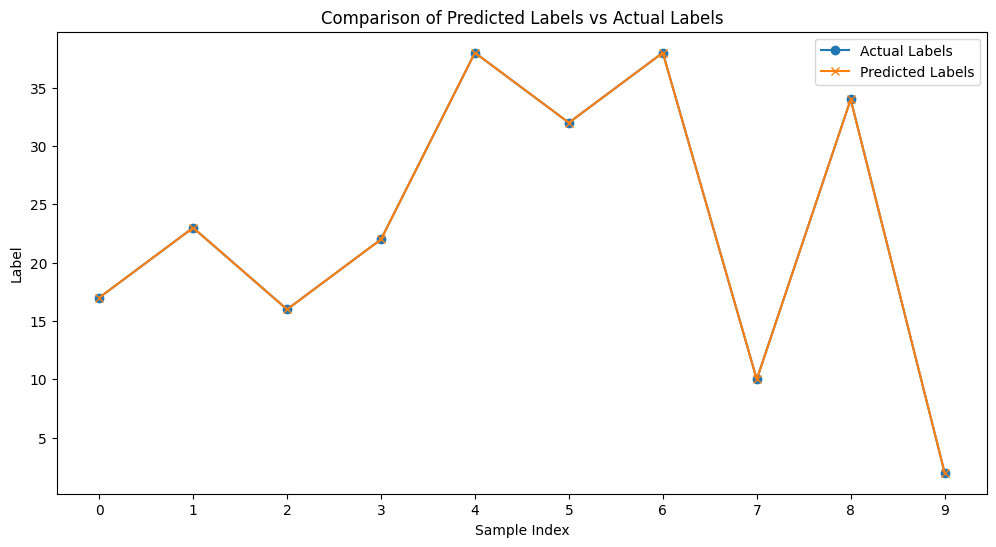

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming model, test_dataloader, device are defined
model.eval()
predictions = []
actual_labels = []

with torch.no_grad():
    for inputs, labels in test_dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        predictions.extend(predicted.cpu().numpy())
        actual_labels.extend(labels.cpu().numpy())

# Convert to numpy arrays for easy handling
predictions = np.array(predictions)
actual_labels = np.array(actual_labels)

# Randomly select a few instances to plot
num_samples_to_display = 10
indices = np.random.choice(range(len(predictions)), num_samples_to_display, replace=False)

selected_predictions = predictions[indices]
selected_actual_labels = actual_labels[indices]

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(selected_actual_labels, 'o-', label='Actual Labels')
plt.plot(selected_predictions, 'x-', label='Predicted Labels')
plt.title('Comparison of Predicted Labels vs Actual Labels')
plt.xlabel('Sample Index')
plt.ylabel('Label')
plt.xticks(range(num_samples_to_display))
plt.legend()
plt.show()


# Saving the Model

In [ ]:
torch.save(model.state_dict(), 'densenet121_state_dict.pth')
